# Compare Previous Violations History With Stim Interactions

**Goal**: Given the validation of the model comparison with the `2023_11_10_EXP_compare_prev_violation_history.ipynb` notebook. Re-implement the model comparison using the model with and without stimulus interaction terms.

The goal of this is to ensure the model comparison code is working as expected and the interaction comparison results are still valid.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from fitting_utils import create_violation_interaction_pairs
from experiment_compare_models import ExperimentCompareModels
from multiclass_logistic_regression import MultiClassLogisticRegression
from model_visualizer import ModelVisualizerCompare
from design_matrix_generator import DesignMatrixGeneratorFilteredHistory, DesignMatrixGeneratorInteractions
sns.set_context("talk")
%load_ext autoreload
%autoreload 2

In [2]:
model_config = {
    "psytrack_features": {  # MODEL 1- pystrack multi base
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
    },
    "filter_prev_violation": {  # MODEL 2- with filt prev violation history
        "model_class": MultiClassLogisticRegression,
        "model_type": "mutli",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
    },
    "filter_prev_violation_stim_itrx": {  # MODEL 3- with filt prev violation history and interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "mutli",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
    },
}
params = {
    "animals": None,
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "null_mode": "multi",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
}

In [3]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(
    file_name="2023_11_16_repeat_compare_prev_violation_stim_interactions.pkl"
)

returning viol dataset for all animals

 >>>> evaluating animal W051 <<<<

 ***** evaluating model psytrack_features w/ sigma 0.07 *****
         Current function value: 41950.303150
         Iterations: 20
         Function evaluations: 88
         Gradient evaluations: 76

 ***** evaluating model psytrack_features w/ sigma 0.13 *****
         Current function value: 41893.656506
         Iterations: 21
         Function evaluations: 85
         Gradient evaluations: 74

 ***** evaluating model psytrack_features w/ sigma 0.25 *****
Optimization terminated successfully.
         Current function value: 41876.171967
         Iterations: 21
         Function evaluations: 35
         Gradient evaluations: 35

 ***** evaluating model psytrack_features w/ sigma 0.5 *****
Optimization terminated successfully.
         Current function value: 41871.260132
         Iterations: 20
         Function evaluations: 33
         Gradient evaluations: 33

 ***** evaluating model psytrack_features w/ s

In [27]:
ORDER = [
    "psytrack_features",
    "filter_prev_violation",
    "filter_prev_violation_stim_itrx",
]

In [ ]:
df.sort_values

In [28]:
mvc = ModelVisualizerCompare(experiment)
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)

# Sort the DataFrame
df = df.sort_values("model_name")

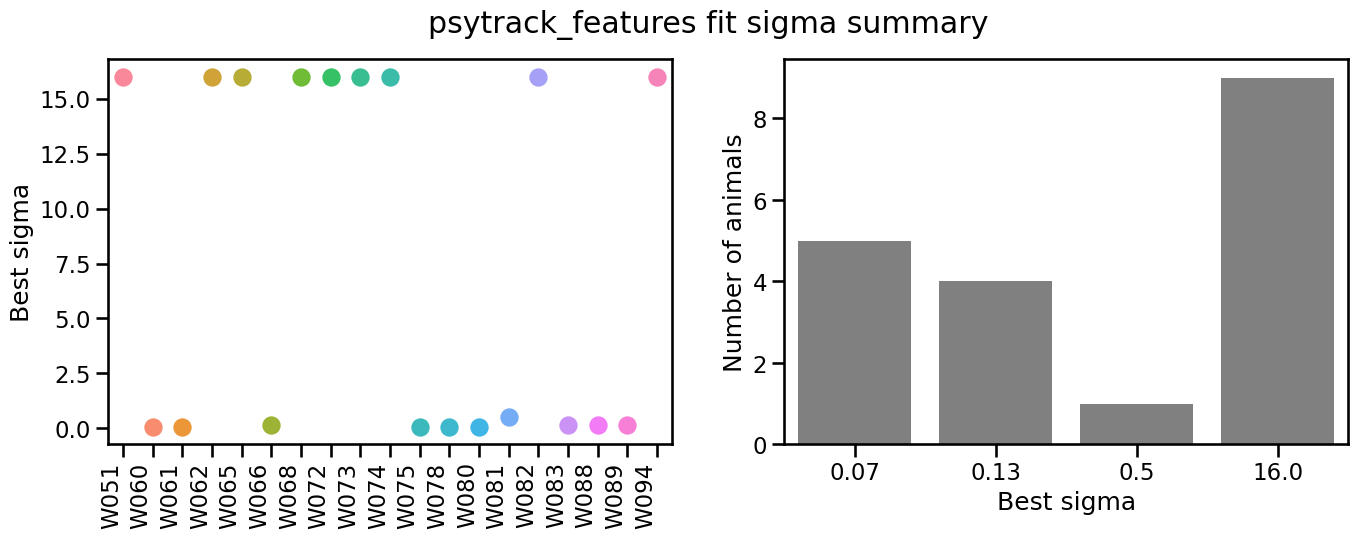

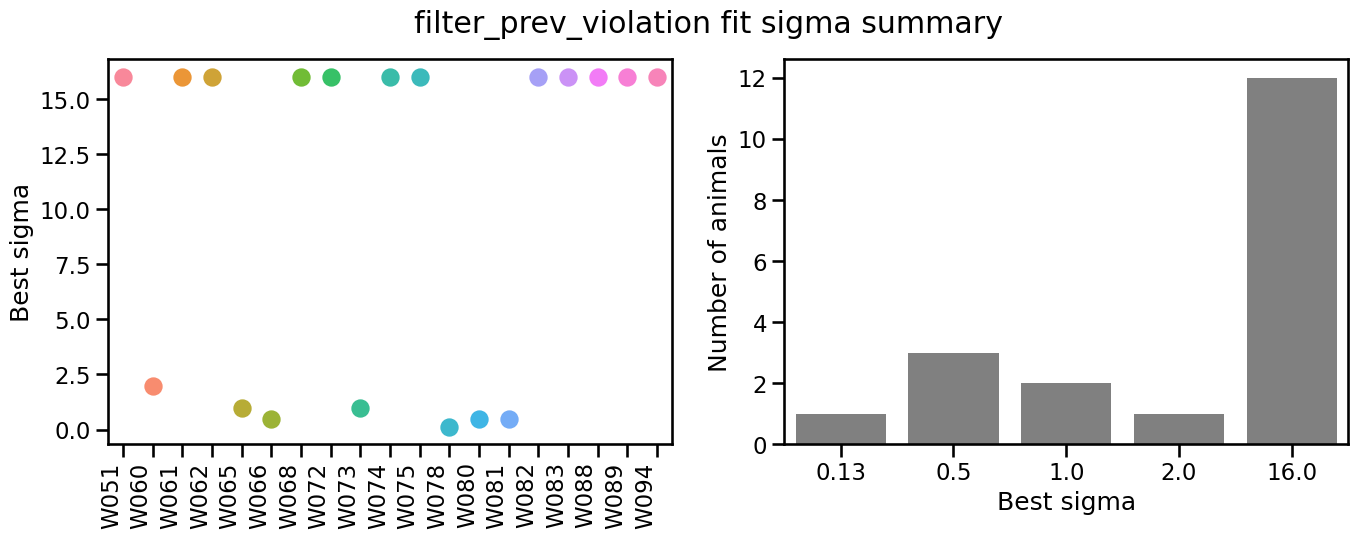

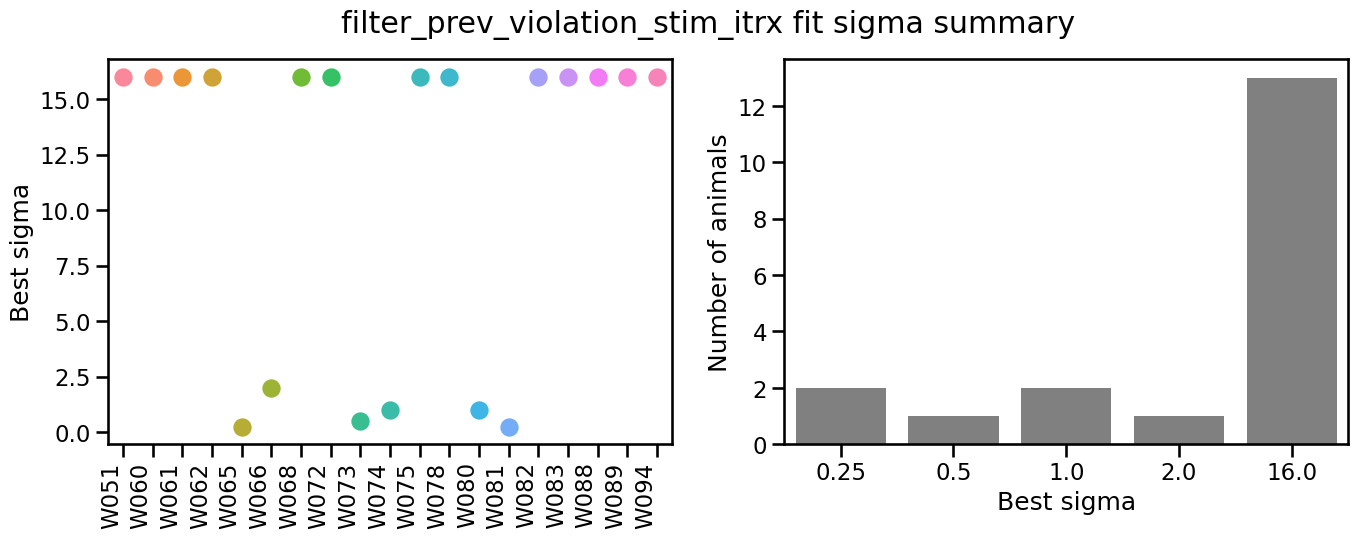

In [29]:
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

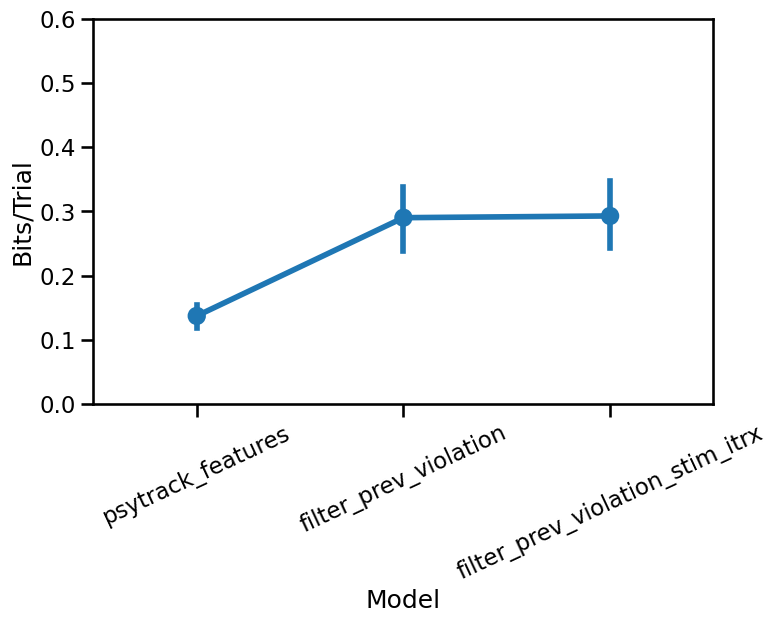

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER,
    ylim=(0, 0.6),
)

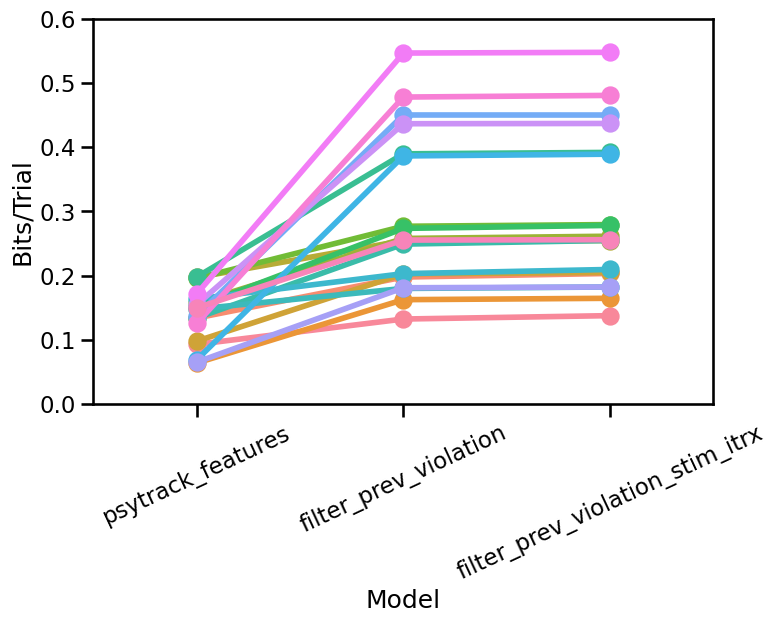

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue="animal_id",
    ax=ax,
    order=ORDER,
    ylim=(0, 0.6),
)

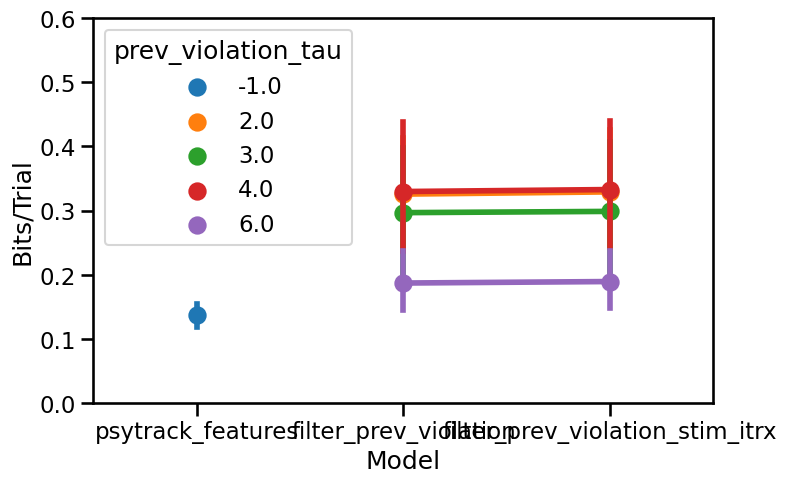

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue="prev_violation_tau",
    ax=ax,
    order=ORDER,
    ylim=(0, 0.6),
)

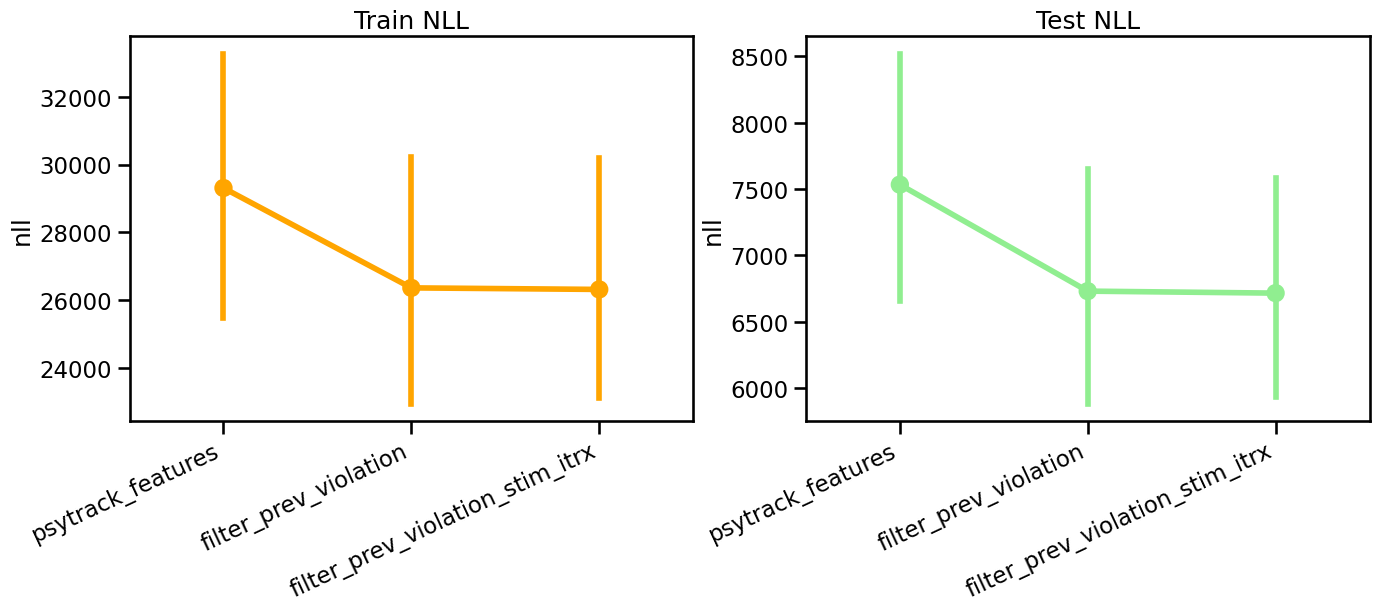

In [36]:
mvc.plot_train_and_test_nll(
    order=ORDER,
)

In [37]:
train_df = mvc.find_best_fit(["animal_id", "model_name"], mode="train")
test_df = mvc.find_best_fit(["animal_id", "model_name"], mode="test")

In [47]:
train_df.groupby(["model_name"]).train_nll.mean()
train_df.groupby(["model_name"]).train_nll.mean()

model_name
filter_prev_violation              26357.331805
filter_prev_violation_stim_itrx    26311.536330
psytrack_features                  29307.867517
Name: train_nll, dtype: float64

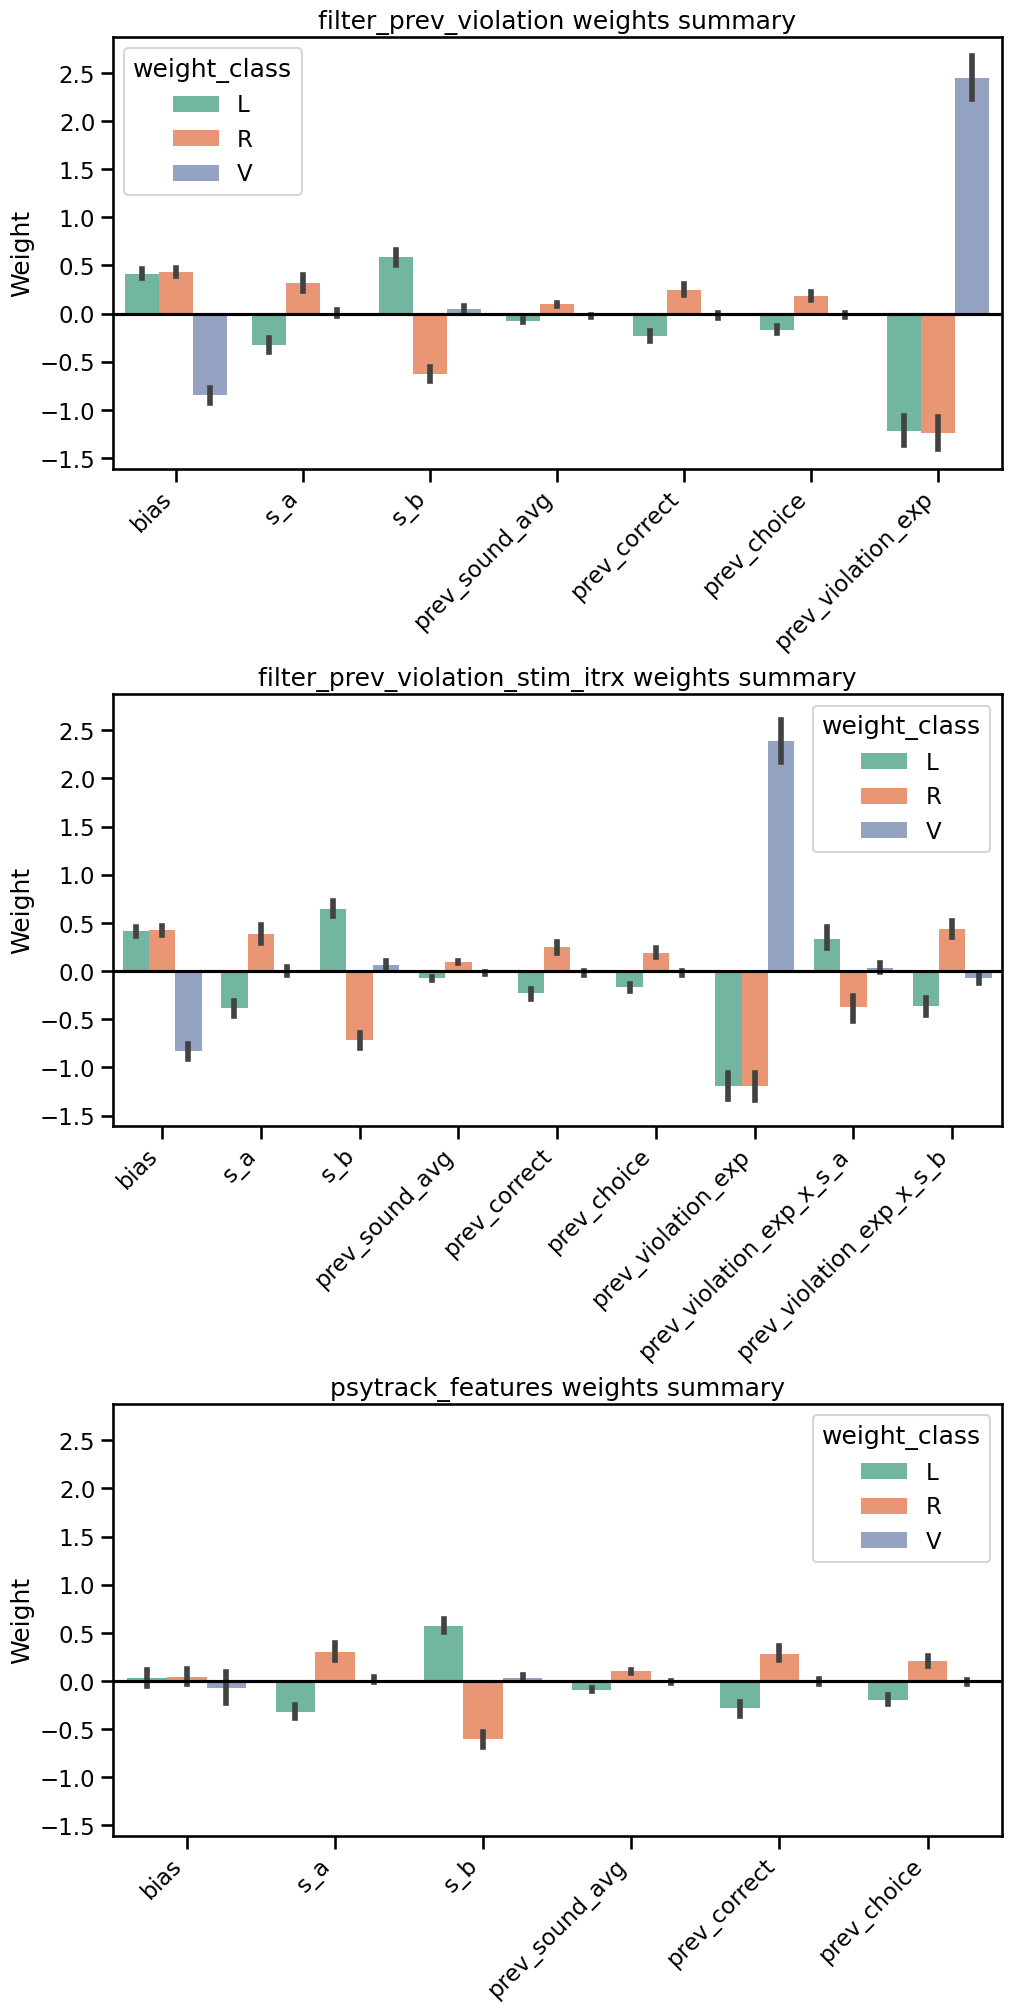

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20), constrained_layout=True, sharey=True)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])
# best_fit_by_model["model_name"] = pd.Categorical(
#     df["model_name"], categories=ORDER, ordered=True
# )
# best_fit_by_model = best_fit_by_model.sort_values("model_name")
for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
        title=f"{model_name} weights summary",
    )

Based on these results- it appears that the previous findings hold. Adding in the prev_violation regressor is so significantly better that adding in interactions only improves the model slightly. Could assess doing prev_violation (no filtered history) with an interactions but it doesn't seem like it would be very worthwhile to keep slicing and dicing.